In [2]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy as sp
import os
import glob
import uuid
import time
from functools import reduce
from EMQST_lib import support_functions as sf
from EMQST_lib import measurement_functions as mf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM
from EMQST_lib import dt
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from EMQST_lib import povm as pv
from numba import jit
#from EMQST_lib import povm
from cvxopt import matrix, solvers
from multiprocessing import Pool
from scipy.optimize import minimize
from itertools import combinations, combinations_with_replacement
from scipy.optimize import curve_fit
%load_ext autoreload
%autoreload 2

In [151]:

fres0 = 8.71567e9
fres1 = 8.83097e9
fres2 = 8.92997e9
fres3 = 8.93862e9

fq0= 347e6+4.1e9
fq1 = 110e6+5.3e9
fq2 = 23e6+4.1e9
fq3 = 125e6+4.8e9


delta_qs = np.abs(np.array([fq1-fq0, fq2-fq0, fq3-fq0, fq2-fq1, fq3-fq1, fq3-fq2]))/10**9
delta_rs = np.abs(np.array([fres1-fres0, fres2-fres0, fres3-fres0, fres2-fres1, fres3-fres1, fres3-fres2]))/10**9
order_r = delta_rs.argsort()
order_q = delta_qs.argsort()
print(delta_qs)
print(delta_rs)

classical_corr_01s =np.array([0.01115, 0.06764, 0.01049, 0.014,  0.03103, 0.08895])
classical_corr_10s =np.array([0.01556, 0.11082, 0.0142,  0.0105, 0.01675, 0.0431])
post_corr_01s =     np.array([0.0044,  0.0001,  0.0019,  0.0061, 0.0002,  0.0116])
post_corr_10s =     np.array([0.0011,  0.0,     0.0011,  0.003,  0.0097,  0.0002])
#total_corrs = (classical_corr_01s+classical_corr_10s+post_corr_01s+post_corr_10s)
total_corrs = classical_corr_01s + classical_corr_10s
total_corr_order = total_corrs.argsort()
def gauss(A, x, sigma):
    return A**2*(1/(np.sqrt(2*np.pi)*sigma))*np.exp(-0.5*(x/sigma)**2)

def prod_fit(Deltas, sigma_q, sigma_r, A):
    delta_q, delta_r = Deltas
    return gauss(A, delta_q, sigma_q)*gauss(1,delta_r,sigma_r)

def sum_fit(Deltas,sigma_q,sigma_r,Q,R):
    delta_q, delta_r = Deltas
    return gauss(Q, delta_q, sigma_q) + gauss(R,delta_r,sigma_r)


def single_fit(Deltas,sigma,A):
    delta_q, delta_r = Deltas
    return gauss(A, delta_q+delta_r, sigma)

def gauss2d(Deltas,sigma_q,sigma_r, sigma_rq, A):
    delta_q, delta_r = Deltas
    return A**2*np.exp(-(delta_q/sigma_q)**2 + (delta_r/sigma_r)**2 + (delta_r*delta_q/(sigma_rq**2)) )

cts = total_corrs
# deltas = []
# for i in range(len(delta_qs)):
#     deltas.append([delta_qs[i], delta_rs[i]])
# deltas = np.array(deltas)
offset = 0
popt_sum, pcov = curve_fit(sum_fit, (delta_qs[offset:] , delta_rs[offset:] ), cts[offset:], maxfev = 10000 )
popt_prod, pcov = curve_fit(prod_fit, (delta_qs[offset:] , delta_rs[offset:] ), cts[offset:], maxfev = 10000 )
popt_single, pcov = curve_fit(single_fit, (delta_qs[offset:] , delta_rs[offset:] ), cts[offset:], maxfev = 10000 )
popt_2d, pcov = curve_fit(gauss2d, (delta_qs[offset:] , delta_rs[offset:] ), cts[offset:], maxfev = 10000 )
print(popt_sum)
print(popt_prod)
print(popt_single)
print(popt_2d)

[0.963 0.324 0.478 1.287 0.485 0.802]
[0.1153  0.2143  0.22295 0.099   0.10765 0.00865]
[ 7.37555962e-01 -1.59112445e+00 -4.63908299e-01  1.39800220e-04]
[0.70519693 0.37616029 0.4707003 ]
[0.62856286 0.50710746]
[ 1.04307171e+00 -1.24804528e+03  1.43763771e+03  3.41184644e-01]


# Plotting

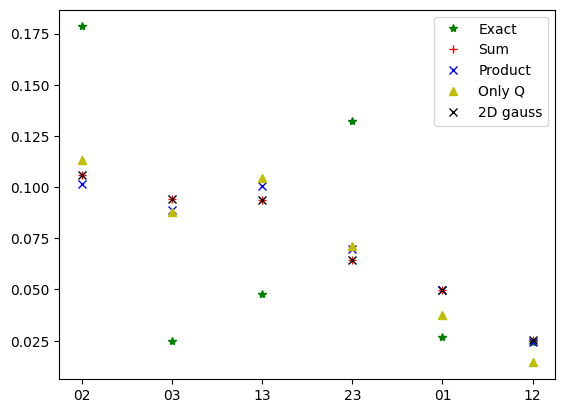

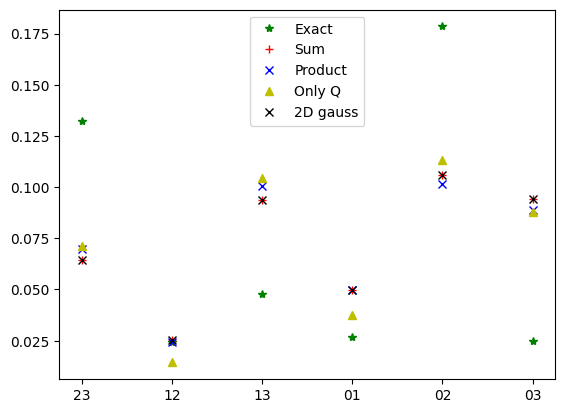

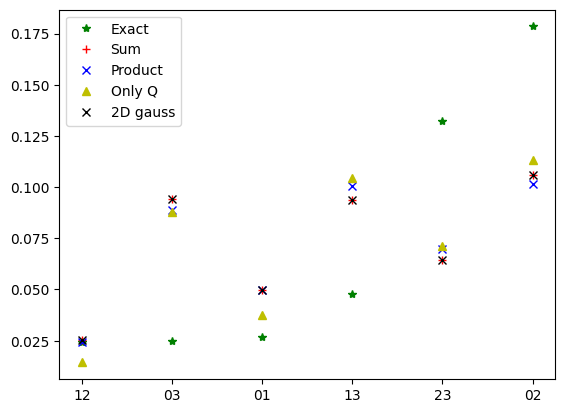

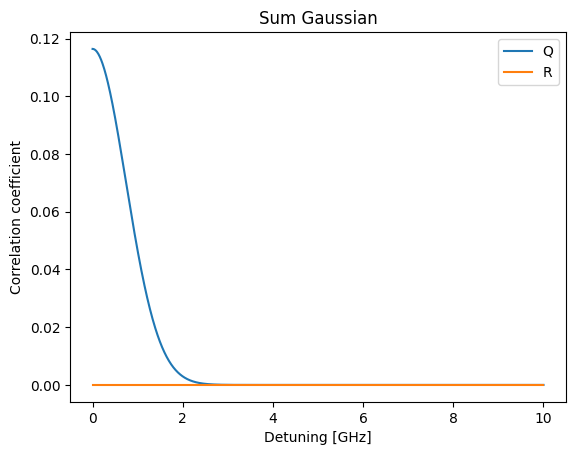

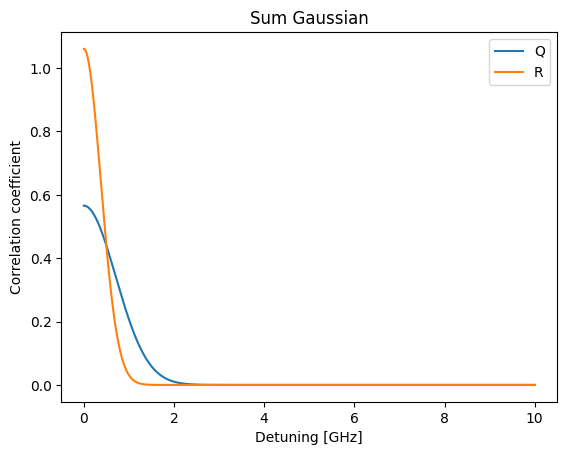

In [152]:
qubit_combs = np.array(["01", "02", "03", "12", "13", "23"])
Deltas = (delta_qs, delta_rs)
gaussian_fit_sum = sum_fit(Deltas,popt_sum[0],popt_sum[1],popt_sum[2],popt_sum[3])
gaussian_fit_prod = prod_fit(Deltas,popt_prod[0],popt_prod[1],popt_prod[2])
gaussian_fit_single = single_fit(Deltas,popt_single[0],popt_single[1])
gaussian_fit_2d = gauss2d(Deltas,popt_2d[0],popt_2d[1],popt_2d[2],popt_2d[3] )
def plot(order):
    plt.plot(qubit_combs[order],cts[order],'g*', label = "Exact")
    plt.plot(qubit_combs[order],gaussian_fit_sum[order],'r+', label = "Sum")
    plt.plot(qubit_combs[order],gaussian_fit_prod[order],'bx', label = "Product")
    plt.plot(qubit_combs[order],gaussian_fit_single[order],'y^', label = "Only Q")
    plt.plot(qubit_combs[order],gaussian_fit_2d[order],'kx', label = "2D gauss")
    plt.legend()
    plt.show()

plot(order_q)
plot(order_r)
plot(total_corr_order)


x = np.linspace(0,10,1000) 
plt.plot(x,gauss(popt_sum[2],x,popt_sum[0]), label = "Q")
plt.plot(x,gauss(popt_sum[3],x,popt_sum[1]), label = "R")
plt.ylabel("Correlation coefficient")
plt.xlabel("Detuning [GHz]")
plt.title("Sum Gaussian")
plt.legend()
plt.show()

plt.plot(x,gauss(1,x,popt_prod[0]), label = "Q")
plt.plot(x,gauss(1,x,popt_prod[1]), label = "R")
plt.ylabel("Correlation coefficient")
plt.xlabel("Detuning [GHz]")
plt.title("Sum Gaussian")
plt.legend()
plt.show()


In [141]:
order = delta_qs.argsort()
print(delta_qs[order])

[1.287 0.963 0.802 0.485 0.478 0.324]


## POVM rotation


In [4]:
n_qubits = 1
X = np.array([[0,1],[1,0]],dtype = complex)
Y = np.array([[0,-1j],[1j,0]],dtype = complex)
Z = np.array([[1,0],[0,-1]],dtype = complex)
sigma = np.array([X,Y,Z],dtype=complex)
    
def rot(axis,angle):
    return sp.linalg.expm(-1/2j * angle * np.einsum('j,jkl->kl',axis,sigma))

rot_x_to_z = rot([0,1,0],np.pi/2)
rot_y_to_z = rot([-1,0,0],np.pi/2)

rot_dict = {
        "X": rot_x_to_z,
        "Y": rot_y_to_z,
        "Z": np.eye(2)
    }


# Example rotate X to Z
# This is for me to generate the povm
pauli_povm = POVM.generate_Pauli_POVM(n_qubits)
pauli_x = pauli_povm[0].get_POVM()
print(pauli_x)

rotated_pauli = pv.rotate_POVM_to_computational_basis(pauli_x,'X')
print(rotated_pauli)


# Example rotate XX to ZZ
n_qubits = 2
pauli_povm = POVM.generate_Pauli_POVM(n_qubits)
pauli_xx = pauli_povm[0].get_POVM() # Pauli XX measurement
rotated_pauli = pv.rotate_POVM_to_computational_basis(pauli_xx,'XX')
print(rotated_pauli) # Computtional basis measurement



[[[ 0.5+0.j  0.5+0.j]
  [ 0.5+0.j  0.5+0.j]]

 [[ 0.5+0.j -0.5+0.j]
  [-0.5+0.j  0.5+0.j]]]
[[[1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j]]]
[[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]]


Check the different QST to QDT shot ratios


Starting EMQST.
----------------------------
Error corrected BME.
POVM calibration states are SIC.
1 qubit(s).
Total shot count using spin measurements: 
12,000 POVM calibration shots.
3,000 QST shots.
1 QST averages.
----------------------------
Synthetic noise mode 2.
Done collecting and sorting QDT data, total runtime 0.0.
Starting POVM reconstruction.
Runtime of parallel POVM reconstruction 1.0137531757354736
Runtime of DT reconstruction 1.0137531757354736
Distance between reconstructed and noisy POVM: 0.02365387803676372
Distance between reconstructed and noisy POVM: 0.022871334592602766
Distance between reconstructed and noisy POVM: 0.016876310555587803
POVM calibration complete.
----------------------------
Generated data.
Start corrected QST.
Completed run 1/1. Final infidelity: 0.01086578870998256.
Corrected QST complete.
----------------------------
Start uncorrected QST.
Completed run 1/1. Final infidelity: 0.10287610684709636.
Uncorrected QST complete.
---------------------

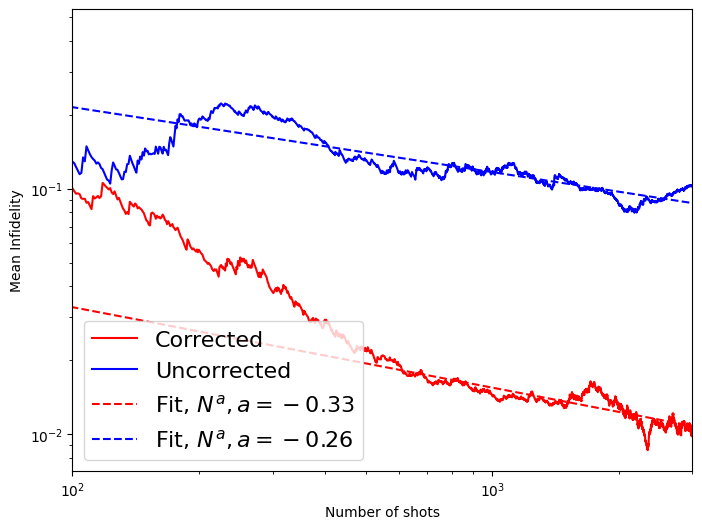

In [31]:
states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(1)])
result = emqst.emqst(n_qubits,1000,1000, states, bool_exp_measurements = False,
                       n_cores = 4, noise_mode = 2, method = 'BME', perform_unmitigated_QST = True, calibration_mode="SIC")

69 110000
Starting EMQST.
----------------------------
Error corrected MLE.
POVM calibration states are SIC.
2 qubit(s).
Total shot count using spin measurements: 
9,936 POVM calibration shots.
990,000 QST shots.
40 QST averages.
----------------------------
Synthetic noise mode 3.
Done collecting and sorting QDT data, total runtime 0.0010008811950683594.
Starting POVM reconstruction.
Runtime of parallel POVM reconstruction 0.7820074558258057
Runtime of DT reconstruction 0.783008337020874
Distance between reconstructed and noisy POVM: 0.07380381552702146
Distance between reconstructed and noisy POVM: 0.06273281481946288
Distance between reconstructed and noisy POVM: 0.06696930251281183
Distance between reconstructed and noisy POVM: 0.0910332669183666
Distance between reconstructed and noisy POVM: 0.07448010693364665
Distance between reconstructed and noisy POVM: 0.06541139584318514
Distance between reconstructed and noisy POVM: 0.08323144374777254
Distance between reconstructed and noi

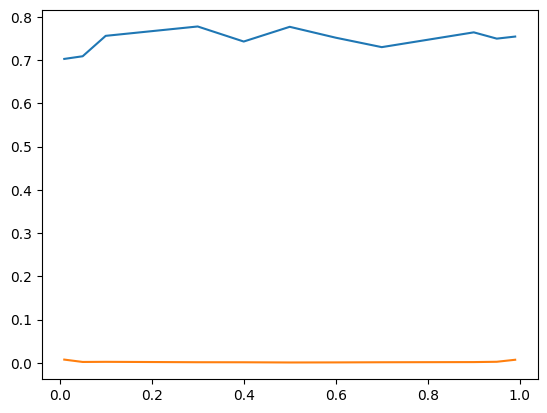

In [119]:
dt_ratios = np.array([0.01,0.05,0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 0.95, 0.99])
last_inf = []
last_inf_corr = []
n_qubits = 2
n_avg = 40
states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(n_avg)])
#states = np.array([sf.generate_random_Hilbert_Schmidt_mixed_state(n_qubits) for _ in range(n_avg)])
n_total = 10**6
noise_mode = 3
for ratio in dt_ratios:
    dt_shot = n_total * ratio / (12**n_qubits) 
    qst_shot = n_total * (1-ratio) / (3**n_qubits)
    print(int(dt_shot), int(qst_shot))
    result = emqst.emqst(n_qubits,int(qst_shot),int(dt_shot), states, bool_exp_measurements = False,
                       n_cores = 4, noise_mode = noise_mode, method = 'MLE', perform_unmitigated_QST = True, calibration_mode="SIC")
    last_inf.append( np.mean(result['uncorrected_infidelity'][:, -1]))
    last_inf_corr.append(np.mean(result['corrected_infidelity'][:,-1]))
print(last_inf)
print(last_inf_corr)

plt.plot(dt_ratios,last_inf, label = "Uncorrected")
plt.plot(dt_ratios,last_inf_corr, label = "Corrected")
plt.show()

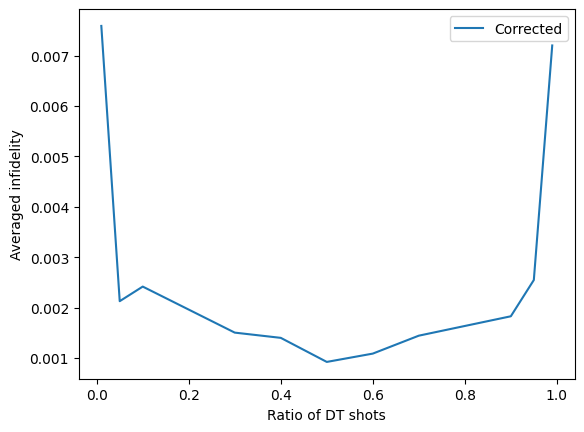

In [121]:
plt.plot(dt_ratios,last_inf_corr, label = "Corrected")
#plt.plot(dt_ratios,last_inf, label = "Uncorrected")
plt.xlabel("Ratio of DT shots")
plt.ylabel("Averaged infidelity")
plt.legend()

plt.show()



In [142]:
n = np.array([1,2,3])

func1 = ((2**n-1)*3**n)/(4**n-1  +((2**n-1)*3**n))
func2 = ((2**n-1)*3**n)/(2**n  +((2**n-1)*3**n))
func3 = (4**n-1)/(1+ 4**n -1)
func4 = 2**n/(1+2**n)
print(func1)
print(func2)
print(func3)
print(func4)

[0.5        0.64285714 0.75      ]
[0.6        0.87096774 0.95939086]
[0.75     0.9375   0.984375]
[0.66666667 0.8        0.88888889]


In [15]:
# Andras needs a way to compute the variance in infidelity of a bank. 
# This would simply be to compute the infidelity between each bank particle and the mean state, multiplied by their respective weights. The definition of variance: 
# Variance = E[inf_of_mean^2]


# Load QST_settings data
path = ""
qst = QST.load_data(path)

print(qst.n_qubits)
print(qst.uncertainty)
print(qst.outcome_index)

# Compute uncertainty
n_qubits = 2
pauli_6 = POVM.generate_Pauli_POVM(n_qubits)
true_states = np.array([sf.generate_random_pure_state(n_qubits) for _ in range(2)])
n_shots = 1000
temp_qst = QST(pauli_6,true_states,n_shots,n_qubits,False,{})
temp_qst.generate_data()
qst = temp_qst
qst.perform_BME(compute_infidelity_uncertainty=True)
uncertainty = qst.get_uncertainty()
print(uncertainty)

Loaded QST settings from 
3
[[0. 0. 0. ... 0. 0. 0.]]
[[  2.   4.   1. ... 208. 208. 208.]]
Completed run 1/2. Final infidelity: 0.0233966605445437.
Completed run 2/2. Final infidelity: 0.029067591999375475.
[[0.         0.         0.         ... 0.         0.         0.00217949]
 [0.         0.         0.         ... 0.         0.         0.00457157]]


## Bootstrapping shot variance 

In [64]:

folder_name_list = glob.glob("shot_variance_results/*")
print(folder_name_list)
for path_to_data_folder in folder_name_list:
    print(f'Processing folder: {path_to_data_folder}')

    n_qubits = 2

    # Load QST_settings data
    qst = QST.load_data(path_to_data_folder+"/")
    # Load DT setting to access QREM POVM.
    with open(f'{path_to_data_folder}/DT_settings.npy','rb') as f:
        povm_dict = np.load(f,allow_pickle=True).item()
    #print(povm_dict)
    recon_POVM_array = povm_dict["reconstructed_POVM_matrix"]
    #print(recon_POVM_array.shape)
    recon_povm = [POVM(recon_POVM_array[i]) for i in range(recon_POVM_array.shape[0])]

    outcomes = qst.get_outcomes()

    resample_size_each = 1556
    total_resample = resample_size_each*len(recon_povm)

    numper_of_resamples = 8
    print(f'Total shot used for each resample: {total_resample}')
    print(f'Number of resamples: {numper_of_resamples}')
    resampled_batches = np.array([[np.random.choice(state,total_resample) for state in outcomes] for _ in range(numper_of_resamples)])
    infidelity = np.zeros((numper_of_resamples,total_resample))
    for i in range(numper_of_resamples):
        print(f'Resample run {i}/{numper_of_resamples}.')
        resample_qst = QST(recon_povm,qst.get_rho_true(),resample_size_each,n_qubits,False,{})
        resample_qst.set_outcomes(resampled_batches[i])
        resample_qst.perform_BME(override_POVM_list = recon_povm)
        infidelity[i] = np.mean(resample_qst.get_infidelity(),axis=0)

    with open(f'{path_to_data_folder}/resampled_infidelities.npy','wb') as f:
        np.save(f,infidelity)

['shot_variance_results\\2024-08-14_23-20-48_a86d1528-c462-45da-9ec5-4630aefe5c70', 'shot_variance_results\\2024-08-14_23-54-20_533c25f5-b998-4e8d-87c9-2a67d079f607', 'shot_variance_results\\2024-08-15_00-28-36_6d39eb63-c6ab-4943-a440-09a73a8662dc', 'shot_variance_results\\2024-08-15_01-02-02_b318b933-5d7f-4d9c-bc0b-548e5f69ad4e', 'shot_variance_results\\2024-08-15_01-35-31_24edf660-56ee-4b9f-8f29-ef581ea16aad', 'shot_variance_results\\2024-08-15_02-09-30_5baba963-375c-45b7-92dc-e327a0d87c73', 'shot_variance_results\\2024-08-15_02-43-03_c2f8b967-91c2-42ee-9e75-189d9050fb58', 'shot_variance_results\\2024-08-15_03-17-07_6b54909e-cbf0-41b9-a9b8-3a17db44679a', 'shot_variance_results\\2024-08-15_03-51-25_a1e9dcbd-dfb8-4d09-b322-15d8330c185e', 'shot_variance_results\\2024-08-15_04-24-56_e95be43f-dc83-48c9-bc53-59217aff6e3a', 'shot_variance_results\\2024-08-15_04-58-16_fe47647d-f72e-4f8e-b355-29d20675ac35']
Processing folder: shot_variance_results\2024-08-14_23-20-48_a86d1528-c462-45da-9ec5-4

Compute crossing and crossing variance

In [66]:
folder_name_list = glob.glob("shot_variance_results/*")
print(folder_name_list)
for path_to_data_folder in folder_name_list:
    # Load infidelities
    #path_to_data_folder = "results/" + folder_name
    with open(f'{path_to_data_folder}/resampled_infidelities.npy','rb') as f:
        infidelity = np.load(f,allow_pickle=True)
        
        
    crossing_threasholds = np.array([0.2,0.15,0.1])
    
    print(infidelity.shape)
    shots_to_cross = np.zeros((len(infidelity),len(crossing_threasholds)),dtype=int)
    for i, threashold in enumerate(crossing_threasholds):
        # 
        shots_to_cross[:,i] = np.argmax(infidelity<threashold,axis=1)
    std = np.std(shots_to_cross,axis=0)  
    print(f'Number of shots to cross threasholds: \n{shots_to_cross}')
    print(f'Standard deviation for threasholds: {crossing_threasholds}: {std}')
    print(f'Final answer should be {np.mean(shots_to_cross,axis=0)} +- {std}')

['shot_variance_results\\2024-08-14_23-20-48_a86d1528-c462-45da-9ec5-4630aefe5c70', 'shot_variance_results\\2024-08-14_23-54-20_533c25f5-b998-4e8d-87c9-2a67d079f607', 'shot_variance_results\\2024-08-15_00-28-36_6d39eb63-c6ab-4943-a440-09a73a8662dc', 'shot_variance_results\\2024-08-15_01-02-02_b318b933-5d7f-4d9c-bc0b-548e5f69ad4e', 'shot_variance_results\\2024-08-15_01-35-31_24edf660-56ee-4b9f-8f29-ef581ea16aad', 'shot_variance_results\\2024-08-15_02-09-30_5baba963-375c-45b7-92dc-e327a0d87c73', 'shot_variance_results\\2024-08-15_02-43-03_c2f8b967-91c2-42ee-9e75-189d9050fb58', 'shot_variance_results\\2024-08-15_03-17-07_6b54909e-cbf0-41b9-a9b8-3a17db44679a', 'shot_variance_results\\2024-08-15_03-51-25_a1e9dcbd-dfb8-4d09-b322-15d8330c185e', 'shot_variance_results\\2024-08-15_04-24-56_e95be43f-dc83-48c9-bc53-59217aff6e3a', 'shot_variance_results\\2024-08-15_04-58-16_fe47647d-f72e-4f8e-b355-29d20675ac35']
(8, 14004)
Number of shots to cross threasholds: 
[[ 746 1377 3707]
 [ 872 1460 3197]
